## Librerías

In [ ]:
import os
import shutil
import subprocess
import numpy as np
import pandas as pd
import scipy.io
import random
from PIL import Image
from copy import copy, deepcopy
from IPython.display import display

import matplotlib.pyplot as plt

from os import listdir
from os.path import join
from tqdm.notebook import tqdm
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split

import torchvision.models as models
import torchvision.transforms as transforms

from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights, ResNet50_Weights, EfficientNet_V2_L_Weights

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


## Load Dataset

In [ ]:
repo_url = 'https://github.com/brendenlake/omniglot.git'
subprocess.call(['git', 'clone', repo_url])

0

In [ ]:
!unzip -qq './omniglot/python/images_background.zip'
!unzip -qq './omniglot/python/strokes_background.zip'

## Orden de las imágenes

En la carpeta images_background, hay 30 alfabetos diferentes. Cada alfabeto contiene una cantidad variada de caracteres, entre 20-50 aprox. Cada uno de los caracteres cuenta es de la forma XXXX_YY.png, donde XXXX corresponde al identificador del caracter, el cual es único entre todos los caracteres de todos los alfabetos. YY corresponde al número de muestra de un caracter en específico, el cual va siempre desde 01 hasta 20 (20 muestras por caracter).

Ahora bien, el problema está en que los XXXX no vienen ordenados secuencialmente en cada uno de los alfabetos. Por lo tanto, para hacer el preprocesamiento, hará un diccionario que mapeará cada uno de los id a un valor ordenado, para que la posterior clasificación sea más rápida.

In [ ]:
img_dir = 'images_background'
# stroke_dir = 'strokes_background'
nreps = 20 # number of renditions for each character
# nalpha = 5 # number of alphabets to show

alphabet_names = sorted([a for a in os.listdir(img_dir) if a[0] != '.']) # get folder names
length_alphabet_names = len(alphabet_names)
character_lengths = [len(os.listdir(os.path.join(img_dir, alph_name))) for alph_name in alphabet_names]

# alphabet_names = random.sample(alphabet_names,nalpha) # choose random alphabets
# print(len(alphabet_names))

N = sum([len(os.listdir(os.path.join(img_dir, alph_name, char)))
            for alph_name in alphabet_names
            for char in os.listdir(os.path.join(img_dir, alph_name))
      ])


y = np.zeros((N), 'int') # ground truth
current_character_folder = 0 # carpeta de un caracter visitado

df_alphabet_names = []
df_character_names = []
df_character_idx = []
df_paths = []
df_y = []

for i in range(len(alphabet_names)):
  alphabet_name = alphabet_names[i]
  character_length = character_lengths[i]
  character_folders = sorted(os.listdir(os.path.join(img_dir, alphabet_name)))

  for j in range(character_length):
    character_folder = character_folders[j]
    characters = sorted(os.listdir(os.path.join(img_dir, alphabet_name, character_folder)))
    # print(character_folder)

    for k in range(nreps):
      y[(current_character_folder * nreps) + k] = current_character_folder

      # Se añade al Df
      df_alphabet_names.extend([alphabet_name])
      df_character_names.extend([character_folder])
      df_character_idx.extend([k])
      df_paths.extend([os.path.join(img_dir, alphabet_name, character_folder, characters[k])])
      df_y.extend([current_character_folder])

    current_character_folder += 1


df = pd.DataFrame({
    'Alphabet': df_alphabet_names,
    'Character': df_character_names,
    'Sample': df_character_idx,
    'Path': df_paths,
    'y': df_y
})

Al observar las muestras que tenemos, se obtiene lo siguiente

In [ ]:
df

,Alphabet,Character,Sample,Path,y
0,Alphabet_of_the_Magi,character01,0,images_background/Alphabet_of_the_Magi/charact...,0
1,Alphabet_of_the_Magi,character01,1,images_background/Alphabet_of_the_Magi/charact...,0
2,Alphabet_of_the_Magi,character01,2,images_background/Alphabet_of_the_Magi/charact...,0
3,Alphabet_of_the_Magi,character01,3,images_background/Alphabet_of_the_Magi/charact...,0
4,Alphabet_of_the_Magi,character01,4,images_background/Alphabet_of_the_Magi/charact...,0
...,...,...,...,...,...
19275,Tifinagh,character55,15,images_background/Tifinagh/character55/0964_16...,963
19276,Tifinagh,character55,16,images_background/Tifinagh/character55/0964_17...,963
19277,Tifinagh,character55,17,images_background/Tifinagh/character55/0964_18...,963
19278,Tifinagh,character55,18,images_background/Tifinagh/character55/0964_19...,963


## Ejemplo de una imagen

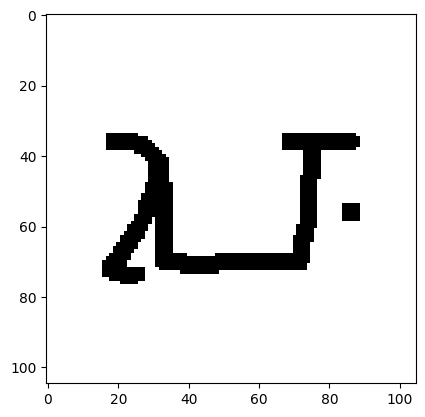

In [ ]:
path = df.iloc[0]['Path']
img = Image.open(path)
# print('Shape:', img.shape)
plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
print(img)

<PIL.PngImagePlugin.PngImageFile image mode=1 size=105x105 at 0x7FC255711930>


## Separación Train - Val - Test:

El objetivo de la ResNet es justamente clasificar cada uno de los caracteres. En total, tenemos 964 caracteres distintos (labels enumerados del 0 al 963), provenientes de 30 alfabetos, y cada caracter posee 20 muestras. Por ende, tenemos 19280 imagenes distintas.

Dado que cada caracter posee 20 muestras, se utilizará una proporción 70% train, 20% validation y 10% test. Vale decir: 14 imágenes de train, 4 de validation, y 2 de test por cada caracter.

En total debería dar:
* 13.496 imágenes de Train
* 3.856 imágenes de Validation
* 1.928 imágenes de Test

In [ ]:
# Separacion de df basados en el numero de fila
df_train = df.groupby('y').head(14)
df_val = df.groupby('y').apply(lambda x: x.iloc[14:18])
df_test = df.groupby('y').apply(lambda x: x.iloc[18:20])

# Reseteamos los indices de los df
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)


In [ ]:
print('Length df_train:', len(df_train))
print('Length df_val:', len(df_val))
print('Length df_test:', len(df_test))

Length df_train: 13496
Length df_val: 3856
Length df_test: 1928


Por ejemplo, si vemos como quedó el df_train:

In [ ]:
df_train[0:20]

,Alphabet,Character,Sample,Path,y
0,Alphabet_of_the_Magi,character01,0,images_background/Alphabet_of_the_Magi/charact...,0
1,Alphabet_of_the_Magi,character01,1,images_background/Alphabet_of_the_Magi/charact...,0
2,Alphabet_of_the_Magi,character01,2,images_background/Alphabet_of_the_Magi/charact...,0
3,Alphabet_of_the_Magi,character01,3,images_background/Alphabet_of_the_Magi/charact...,0
4,Alphabet_of_the_Magi,character01,4,images_background/Alphabet_of_the_Magi/charact...,0
5,Alphabet_of_the_Magi,character01,5,images_background/Alphabet_of_the_Magi/charact...,0
6,Alphabet_of_the_Magi,character01,6,images_background/Alphabet_of_the_Magi/charact...,0
7,Alphabet_of_the_Magi,character01,7,images_background/Alphabet_of_the_Magi/charact...,0
8,Alphabet_of_the_Magi,character01,8,images_background/Alphabet_of_the_Magi/charact...,0
9,Alphabet_of_the_Magi,character01,9,images_background/Alphabet_of_the_Magi/charact...,0


## Modelo EfficientNet

In [ ]:
num_classes = 964 # Cantidad de clases que hay

In [ ]:
model = models.efficientnet_v2_l(weights=EfficientNet_V2_L_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Linear(1280, num_classes, bias=True)
model.aux_logits=False
model.to(device)

for param in model.parameters(): param.requires_grad = False

# Descongelamos la última capa
for param in model.classifier.parameters(): param.requires_grad = True

summary(model, input_size=(3, 105, 105))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.7)

## Train

In [ ]:
class Character(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.transform = transform
        self.images = images     # Vincula el indice con un nombre de archivo
        self.labels = labels     # Vincula el indice con una clase

    def get_image(self, path):
        # img = plt.imread(path)
        img = Image.open(path)
        return img

    def __getitem__(self, idx):
        path_name = self.images[idx]
        label = self.labels[idx]
        img = self.get_image(path_name)

        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.images)

In [ ]:
# Set up data transformations
transform = Compose([
    lambda x: x.convert('RGB'),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_dataset = Character(images=df_train['Path'], labels=df_train['y'], transform=transform)
val_dataset = Character(images=df_val['Path'], labels=df_val['y'], transform=transform)
test_dataset = Character(images=df_test['Path'], labels=df_test['y'], transform=transform)

In [ ]:
print('Train Dataset Length:', len(train_dataset))
print('Val Dataset Length:', len(val_dataset))
print('Test Dataset Length:', len(test_dataset))

Train Dataset Length: 13496
Val Dataset Length: 3856
Test Dataset Length: 1928


In [ ]:
# Set up the train loader
batch_size = 64
shuffle = True
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

In [ ]:
trainiter = iter(train_loader)
features, labels = next(trainiter)
print(features.shape, labels.shape)

torch.Size([64, 3, 105, 105]) torch.Size([64])


In [ ]:
len(train_loader)

211

In [ ]:
os.makedirs('models', exist_ok=True)
model_path = 'models/EfficientNet'


## Test

In [ ]:
# Función para correr inferencia usando un modelo y un
# DataLoader con nuestros datos del set de test.
def test_model(model, test_dl):
    total_correctas = 0.0
    total_muestras = 0.0

    for x, target in test_dl:          # Iteramos sobre nuestros datos
        # Inicio de la iteración
        model.eval()                        # Dejamos el modelo en modo evaluación
        with torch.no_grad():               # No se calculará información de gradientes
                                            # en el código de más abajo.
            x = x.cuda()
            target = target.cuda()          # Enviamos nuestros datos a GPU
            output = model(x)               # Hacemos el forward de nuestros datos

            preds = output.argmax(dim=1)             # El máximo valor es nuestra predicción
            correctas = (preds == target).sum()      # Acumulamos las correctas durante la época
            total_correctas += correctas
            total_muestras += target.shape[0]        # Sumamos el tamaño del batch

            accuracy = total_correctas/total_muestras # Acc = correctas/total

    return accuracy

In [ ]:
model = models.efficientnet_v2_l(weights=EfficientNet_V2_L_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Linear(1280, num_classes, bias=True)
model.aux_logits=False
model.to(device)

for param in model.parameters(): param.requires_grad = False

# Descongelamos la última capa
for param in model.classifier.parameters(): param.requires_grad = True

summary(model, input_size=(3, 105, 105))

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.7)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# optimizer = optim.Adagrad(model.parameters(), lr=0.009, lr_decay=0.0001)
# optimizer = optim.ASGD(model.parameters(), lr=0.01)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 53, 53]             864
       BatchNorm2d-2           [-1, 32, 53, 53]              64
              SiLU-3           [-1, 32, 53, 53]               0
            Conv2d-4           [-1, 32, 53, 53]           9,216
       BatchNorm2d-5           [-1, 32, 53, 53]              64
              SiLU-6           [-1, 32, 53, 53]               0
   StochasticDepth-7           [-1, 32, 53, 53]               0
       FusedMBConv-8           [-1, 32, 53, 53]               0
            Conv2d-9           [-1, 32, 53, 53]           9,216
      BatchNorm2d-10           [-1, 32, 53, 53]              64
             SiLU-11           [-1, 32, 53, 53]               0
  StochasticDepth-12           [-1, 32, 53, 53]               0
      FusedMBConv-13           [-1, 32, 53, 53]               0
           Conv2d-14           [-1, 32,

| Modelo | Optimizador | Learning Rate | Params | Epoch | Acc Train | Acc Val | Acc Test |
| -----  | ----- | ---- | ---- | ---- | ---- | ---- | ---- |
| EfficientNet | SGD |  | | | | | |
| EfficientNet | Adam | 1e-4 | | 51 | 0.999 | 0.395 | 0.432 |
| EfficientNet | Adam | 8e-2 | | 5 | 0.924 | 0.232 | 0.256 |
| EfficientNet | Adam | 2e-3 | | 10 | 0.999 | 0.392 | 0.406 |
| EfficientNet | Adam | 8e-3 | | 5 | 0.997 | 0.310| 0.332 |
| EfficientNet | Adam | 1e-2 | | 5 | 0.993 | 0.293| 0.345 |
| EfficientNet | Adam | 4e-2 | | 6 | 0.942 | 0.239| 0.265 |
| EfficientNet | Adam | 4e-4 | betas=(0.8, 0.9)| 7 | 0.987 | 0.392| 0.423 |
| EfficientNet | Adagrad | 0.009 |lr_decay=0.0001 | 100 | 0.999 | 0.383 | 0.423 |
| EfficientNet | ASGD | 0.01 | | 10 | 0.49 | 0.156 | 0.179 |

In [ ]:
# Para guardar los valores que queremos visualizar
ovrl_history = {
    'epochs': [],
    'train': {'loss': [], 'acc': []},
    'val': {'loss': [], 'acc': []},
    'test': {'loss': [], 'acc': []},
}

n_epochs = 100

for epoch in range(n_epochs):
    losses = []
    cum_loss = 0.0
    cum_acc = 0.0
    with tqdm(train_loader, unit='batch', position=0, leave=True) as tepoch:
      tepoch.set_description(f"Epoch {epoch}/{n_epochs}")
      for batch, (data, targets) in enumerate(tepoch, start=1):
        optimizer.zero_grad()
        data = data.to(device)
        targets = targets.to(device)

        preds = model(data)
        loss = criterion(preds, targets)

        loss.backward()
        optimizer.step()

        _, preds = torch.max(preds, dim=1)
        cum_acc += torch.sum(preds == targets)

        # Cifras de desempeño
        cum_loss += loss.item()
        curr_loss = cum_loss / batch
        curr_acc = cum_acc / (batch * batch_size)
        tepoch.set_postfix(Loss=curr_loss, Acc=curr_acc.item())
        losses.append(loss.item())

        torch.cuda.empty_cache()

    epoch_loss = float(cum_loss / batch)
    epoch_acc = float(cum_acc / (batch * batch_size))

    # Guardamos la epoca
    ovrl_history['epochs'].append(epoch)

    # Guardamos el loss y accuracy para la epoca
    ovrl_history['train']['loss'].append(epoch_loss)
    ovrl_history['train']['acc'].append(epoch_acc)

    # Guardamos el loss y accuracy en el set de validacion
    val_acc = test_model(model, val_loader)
    ovrl_history['val']['loss'].append(epoch_loss)
    ovrl_history['val']['acc'].append(float(val_acc))
    print(f'Validation Accuracy: {val_acc}')

    # Guardamos el loss y accuracy en el set de testing
    test_acc = test_model(model, test_loader)
    ovrl_history['test']['acc'].append(float(test_acc))
    print(f'Testing Accuracy: {test_acc}')

    # Guardamos el progreso actual en caso de que se corte la sesión.
    # Debe existir el directorio
    # Se guarda cada una de las epocas distintas para despues graficarla
    torch.save(model, model_path + '_' + str(epoch).zfill(3) + '.pt')

    print(f'Epoch {epoch + 1} finished\n')

Epoch 0/100: 100%|██████████| 211/211 [00:52<00:00,  4.01batch/s, Acc=0.00237, Loss=6.95]


Validation Accuracy: 0.020487552508711815
Testing Accuracy: 0.01815352775156498
Epoch 1 finished



Epoch 1/100: 100%|██████████| 211/211 [00:52<00:00,  3.99batch/s, Acc=0.0727, Loss=6.13]


Validation Accuracy: 0.08065353333950043
Testing Accuracy: 0.0684647336602211
Epoch 2 finished



Epoch 2/100: 100%|██████████| 211/211 [00:52<00:00,  4.05batch/s, Acc=0.26, Loss=5.5]


Validation Accuracy: 0.14211618900299072
Testing Accuracy: 0.14315353333950043
Epoch 3 finished



Epoch 3/100: 100%|██████████| 211/211 [00:52<00:00,  4.05batch/s, Acc=0.485, Loss=4.88]


Validation Accuracy: 0.19035270810127258
Testing Accuracy: 0.21058093011379242
Epoch 4 finished



Epoch 4/100: 100%|██████████| 211/211 [00:52<00:00,  4.04batch/s, Acc=0.671, Loss=4.29]


Validation Accuracy: 0.23236516118049622
Testing Accuracy: 0.25570541620254517
Epoch 5 finished



Epoch 5/100: 100%|██████████| 211/211 [00:52<00:00,  4.04batch/s, Acc=0.788, Loss=3.73]


Validation Accuracy: 0.259854793548584
Testing Accuracy: 0.2847510576248169
Epoch 6 finished



Epoch 6/100: 100%|██████████| 211/211 [00:52<00:00,  4.05batch/s, Acc=0.862, Loss=3.22]


Validation Accuracy: 0.2889004349708557
Testing Accuracy: 0.3117220103740692
Epoch 7 finished



Epoch 7/100: 100%|██████████| 211/211 [00:52<00:00,  4.05batch/s, Acc=0.909, Loss=2.77]


Validation Accuracy: 0.3106846511363983
Testing Accuracy: 0.3433610200881958
Epoch 8 finished



Epoch 8/100: 100%|██████████| 211/211 [00:52<00:00,  4.05batch/s, Acc=0.94, Loss=2.37]


Validation Accuracy: 0.3254668116569519
Testing Accuracy: 0.3589211702346802
Epoch 9 finished



Epoch 9/100: 100%|██████████| 211/211 [00:52<00:00,  4.05batch/s, Acc=0.957, Loss=2.02]


Validation Accuracy: 0.33973032236099243
Testing Accuracy: 0.37344399094581604
Epoch 10 finished



Epoch 10/100: 100%|██████████| 211/211 [00:52<00:00,  4.05batch/s, Acc=0.969, Loss=1.73]


Validation Accuracy: 0.35165977478027344
Testing Accuracy: 0.3869294822216034
Epoch 11 finished



Epoch 11/100: 100%|██████████| 211/211 [00:52<00:00,  4.05batch/s, Acc=0.978, Loss=1.48]


Validation Accuracy: 0.3581431806087494
Testing Accuracy: 0.3947095572948456
Epoch 12 finished



Epoch 12/100: 100%|██████████| 211/211 [00:52<00:00,  4.05batch/s, Acc=0.984, Loss=1.26]


Validation Accuracy: 0.36566391587257385
Testing Accuracy: 0.39056017994880676
Epoch 13 finished



Epoch 13/100: 100%|██████████| 211/211 [00:52<00:00,  4.04batch/s, Acc=0.989, Loss=1.08]


Validation Accuracy: 0.36851662397384644
Testing Accuracy: 0.39834028482437134
Epoch 14 finished



Epoch 14/100: 100%|██████████| 211/211 [00:52<00:00,  4.05batch/s, Acc=0.992, Loss=0.929]


Validation Accuracy: 0.37240666151046753
Testing Accuracy: 0.4030083119869232
Epoch 15 finished



Epoch 15/100: 100%|██████████| 211/211 [00:52<00:00,  4.05batch/s, Acc=0.993, Loss=0.8]


Validation Accuracy: 0.3768153786659241
Testing Accuracy: 0.40923237800598145
Epoch 16 finished



Epoch 16/100: 100%|██████████| 211/211 [00:52<00:00,  4.05batch/s, Acc=0.995, Loss=0.689]


Validation Accuracy: 0.37655603885650635
Testing Accuracy: 0.40923237800598145
Epoch 17 finished



Epoch 17/100: 100%|██████████| 211/211 [00:52<00:00,  4.05batch/s, Acc=0.996, Loss=0.594]


Validation Accuracy: 0.37940874695777893
Testing Accuracy: 0.4149377942085266
Epoch 18 finished



Epoch 18/100: 100%|██████████| 211/211 [00:52<00:00,  4.06batch/s, Acc=0.997, Loss=0.514]


Validation Accuracy: 0.3827801048755646
Testing Accuracy: 0.4154564440250397
Epoch 19 finished



Epoch 19/100: 100%|██████████| 211/211 [00:52<00:00,  4.05batch/s, Acc=0.998, Loss=0.445]


Validation Accuracy: 0.3851141333580017
Testing Accuracy: 0.4139004349708557
Epoch 20 finished



Epoch 20/100: 100%|██████████| 211/211 [00:51<00:00,  4.07batch/s, Acc=0.998, Loss=0.386]


Validation Accuracy: 0.3869294822216034
Testing Accuracy: 0.41856849193573
Epoch 21 finished



Epoch 21/100: 100%|██████████| 211/211 [00:52<00:00,  4.06batch/s, Acc=0.998, Loss=0.335]


Validation Accuracy: 0.38641080260276794
Testing Accuracy: 0.4196058213710785
Epoch 22 finished



Epoch 22/100: 100%|██████████| 211/211 [00:52<00:00,  4.05batch/s, Acc=0.999, Loss=0.292]


Validation Accuracy: 0.3858921229839325
Testing Accuracy: 0.42116186022758484
Epoch 23 finished



Epoch 23/100: 100%|██████████| 211/211 [00:51<00:00,  4.06batch/s, Acc=0.999, Loss=0.255]


Validation Accuracy: 0.38848549127578735
Testing Accuracy: 0.4216805100440979
Epoch 24 finished



Epoch 24/100: 100%|██████████| 211/211 [00:51<00:00,  4.07batch/s, Acc=0.999, Loss=0.223]


Validation Accuracy: 0.3900415003299713
Testing Accuracy: 0.4206431806087494
Epoch 25 finished



Epoch 25/100: 100%|██████████| 211/211 [00:51<00:00,  4.06batch/s, Acc=0.999, Loss=0.196]


Validation Accuracy: 0.389782190322876
Testing Accuracy: 0.42427387833595276
Epoch 26 finished



Epoch 26/100: 100%|██████████| 211/211 [00:51<00:00,  4.06batch/s, Acc=0.999, Loss=0.172]


Validation Accuracy: 0.3887448310852051
Testing Accuracy: 0.4247925579547882
Epoch 27 finished



Epoch 27/100: 100%|██████████| 211/211 [00:51<00:00,  4.06batch/s, Acc=0.999, Loss=0.152]


Validation Accuracy: 0.3908195197582245
Testing Accuracy: 0.42323654890060425
Epoch 28 finished



Epoch 28/100: 100%|██████████| 211/211 [00:51<00:00,  4.07batch/s, Acc=0.999, Loss=0.134]


Validation Accuracy: 0.39056017994880676
Testing Accuracy: 0.4227178692817688
Epoch 29 finished



Epoch 29/100: 100%|██████████| 211/211 [00:51<00:00,  4.06batch/s, Acc=0.999, Loss=0.119]


Validation Accuracy: 0.3892635107040405
Testing Accuracy: 0.428941935300827
Epoch 30 finished



Epoch 30/100: 100%|██████████| 211/211 [00:51<00:00,  4.06batch/s, Acc=0.999, Loss=0.105]


Validation Accuracy: 0.39159753918647766
Testing Accuracy: 0.42738592624664307
Epoch 31 finished



Epoch 31/100: 100%|██████████| 211/211 [00:51<00:00,  4.06batch/s, Acc=0.999, Loss=0.0937]


Validation Accuracy: 0.39030084013938904
Testing Accuracy: 0.42634856700897217
Epoch 32 finished



Epoch 32/100: 100%|██████████| 211/211 [00:51<00:00,  4.06batch/s, Acc=0.999, Loss=0.0836]


Validation Accuracy: 0.3900415003299713
Testing Accuracy: 0.42790457606315613
Epoch 33 finished



Epoch 33/100: 100%|██████████| 211/211 [00:52<00:00,  4.04batch/s, Acc=0.999, Loss=0.0747]


Validation Accuracy: 0.3908195197582245
Testing Accuracy: 0.4294606149196625
Epoch 34 finished



Epoch 34/100: 100%|██████████| 211/211 [00:52<00:00,  4.05batch/s, Acc=0.999, Loss=0.0669]


Validation Accuracy: 0.39237552881240845
Testing Accuracy: 0.4294606149196625
Epoch 35 finished



Epoch 35/100: 100%|██████████| 211/211 [00:52<00:00,  4.05batch/s, Acc=0.999, Loss=0.06]


Validation Accuracy: 0.3918568789958954
Testing Accuracy: 0.428941935300827
Epoch 36 finished



Epoch 36/100: 100%|██████████| 211/211 [00:51<00:00,  4.06batch/s, Acc=0.999, Loss=0.054]


Validation Accuracy: 0.39159753918647766
Testing Accuracy: 0.43101662397384644
Epoch 37 finished



Epoch 37/100: 100%|██████████| 211/211 [00:52<00:00,  4.06batch/s, Acc=0.999, Loss=0.0486]


Validation Accuracy: 0.3921161890029907
Testing Accuracy: 0.4284232556819916
Epoch 38 finished



Epoch 38/100: 100%|██████████| 211/211 [00:52<00:00,  4.05batch/s, Acc=0.999, Loss=0.0438]


Validation Accuracy: 0.3918568789958954
Testing Accuracy: 0.4294606149196625
Epoch 39 finished



Epoch 39/100: 100%|██████████| 211/211 [00:52<00:00,  4.05batch/s, Acc=0.999, Loss=0.0396]


Validation Accuracy: 0.3918568789958954
Testing Accuracy: 0.4294606149196625
Epoch 40 finished



Epoch 40/100: 100%|██████████| 211/211 [00:52<00:00,  4.04batch/s, Acc=0.999, Loss=0.0358]


Validation Accuracy: 0.3910788595676422
Testing Accuracy: 0.42997926473617554
Epoch 41 finished



Epoch 41/100: 100%|██████████| 211/211 [00:52<00:00,  4.05batch/s, Acc=0.999, Loss=0.0324]


Validation Accuracy: 0.39030084013938904
Testing Accuracy: 0.43101662397384644
Epoch 42 finished



Epoch 42/100: 100%|██████████| 211/211 [00:51<00:00,  4.06batch/s, Acc=0.999, Loss=0.0294]


Validation Accuracy: 0.3918568789958954
Testing Accuracy: 0.43205395340919495
Epoch 43 finished



Epoch 43/100: 100%|██████████| 211/211 [00:52<00:00,  4.05batch/s, Acc=0.999, Loss=0.0267]


Validation Accuracy: 0.3910788595676422
Testing Accuracy: 0.4315353035926819
Epoch 44 finished



Epoch 44/100: 100%|██████████| 211/211 [00:51<00:00,  4.06batch/s, Acc=0.999, Loss=0.0242]


Validation Accuracy: 0.3910788595676422
Testing Accuracy: 0.42997926473617554
Epoch 45 finished



Epoch 45/100: 100%|██████████| 211/211 [00:52<00:00,  4.05batch/s, Acc=0.999, Loss=0.0221]


Validation Accuracy: 0.3918568789958954
Testing Accuracy: 0.4315353035926819
Epoch 46 finished



Epoch 46/100: 100%|██████████| 211/211 [00:52<00:00,  4.04batch/s, Acc=0.999, Loss=0.0201]


Validation Accuracy: 0.39159753918647766
Testing Accuracy: 0.4315353035926819
Epoch 47 finished



Epoch 47/100: 100%|██████████| 211/211 [00:52<00:00,  4.05batch/s, Acc=0.999, Loss=0.0183]


Validation Accuracy: 0.39419087767601013
Testing Accuracy: 0.42997926473617554
Epoch 48 finished



Epoch 48/100: 100%|██████████| 211/211 [00:52<00:00,  4.06batch/s, Acc=0.999, Loss=0.0167]


Validation Accuracy: 0.39367222785949707
Testing Accuracy: 0.43101662397384644
Epoch 49 finished



Epoch 49/100: 100%|██████████| 211/211 [00:52<00:00,  4.05batch/s, Acc=0.999, Loss=0.0152]


Validation Accuracy: 0.39341288805007935
Testing Accuracy: 0.4325726330280304
Epoch 50 finished



Epoch 50/100: 100%|██████████| 211/211 [00:52<00:00,  4.06batch/s, Acc=0.999, Loss=0.0139]


Validation Accuracy: 0.39522823691368103
Testing Accuracy: 0.43205395340919495
Epoch 51 finished



Epoch 51/100: 100%|██████████| 211/211 [00:52<00:00,  4.04batch/s, Acc=0.999, Loss=0.0127]


Validation Accuracy: 0.3949688971042633
Testing Accuracy: 0.4315353035926819
Epoch 52 finished



Epoch 52/100: 100%|██████████| 211/211 [00:52<00:00,  4.06batch/s, Acc=0.999, Loss=0.0116]


Validation Accuracy: 0.3931535482406616
Testing Accuracy: 0.42997926473617554
Epoch 53 finished



Epoch 53/100: 100%|██████████| 211/211 [00:52<00:00,  4.05batch/s, Acc=0.999, Loss=0.0106]


Validation Accuracy: 0.39341288805007935
Testing Accuracy: 0.43205395340919495
Epoch 54 finished



Epoch 54/100: 100%|██████████| 211/211 [00:52<00:00,  4.04batch/s, Acc=0.999, Loss=0.00967]


Validation Accuracy: 0.39341288805007935
Testing Accuracy: 0.43205395340919495
Epoch 55 finished



Epoch 55/100: 100%|██████████| 211/211 [00:52<00:00,  4.05batch/s, Acc=0.999, Loss=0.00885]


Validation Accuracy: 0.39522823691368103
Testing Accuracy: 0.43309131264686584
Epoch 56 finished



Epoch 56/100: 100%|██████████| 211/211 [00:52<00:00,  4.05batch/s, Acc=0.999, Loss=0.0081]


Validation Accuracy: 0.3957469165325165
Testing Accuracy: 0.43309131264686584
Epoch 57 finished



Epoch 57/100: 100%|██████████| 211/211 [00:52<00:00,  4.05batch/s, Acc=0.999, Loss=0.00742]


Validation Accuracy: 0.3957469165325165
Testing Accuracy: 0.4336099922657013
Epoch 58 finished



Epoch 58/100: 100%|██████████| 211/211 [00:52<00:00,  4.05batch/s, Acc=0.999, Loss=0.00679]


Validation Accuracy: 0.39445021748542786
Testing Accuracy: 0.4336099922657013
Epoch 59 finished



Epoch 59/100: 100%|██████████| 211/211 [00:51<00:00,  4.06batch/s, Acc=0.999, Loss=0.00622]


Validation Accuracy: 0.39367222785949707
Testing Accuracy: 0.43309131264686584
Epoch 60 finished



Epoch 60/100: 100%|██████████| 211/211 [00:52<00:00,  4.06batch/s, Acc=0.999, Loss=0.0057]


Validation Accuracy: 0.396784245967865
Testing Accuracy: 0.43412864208221436
Epoch 61 finished



Epoch 61/100: 100%|██████████| 211/211 [00:52<00:00,  4.04batch/s, Acc=0.999, Loss=0.00523]


Validation Accuracy: 0.39652490615844727
Testing Accuracy: 0.4346473217010498
Epoch 62 finished



Epoch 62/100: 100%|██████████| 211/211 [00:52<00:00,  4.05batch/s, Acc=0.999, Loss=0.00479]


Validation Accuracy: 0.3970435857772827
Testing Accuracy: 0.43412864208221436
Epoch 63 finished



Epoch 63/100: 100%|██████████| 211/211 [00:52<00:00,  4.05batch/s, Acc=0.999, Loss=0.0044]


Validation Accuracy: 0.39730292558670044
Testing Accuracy: 0.43412864208221436
Epoch 64 finished



Epoch 64/100: 100%|██████████| 211/211 [00:52<00:00,  4.06batch/s, Acc=0.999, Loss=0.00403]


Validation Accuracy: 0.39652490615844727
Testing Accuracy: 0.4346473217010498
Epoch 65 finished



Epoch 65/100: 100%|██████████| 211/211 [00:52<00:00,  4.04batch/s, Acc=0.999, Loss=0.0037]


Validation Accuracy: 0.39730292558670044
Testing Accuracy: 0.43309131264686584
Epoch 66 finished



Epoch 66/100: 100%|██████████| 211/211 [00:52<00:00,  4.05batch/s, Acc=0.999, Loss=0.0034]


Validation Accuracy: 0.39626556634902954
Testing Accuracy: 0.4325726330280304
Epoch 67 finished



Epoch 67/100: 100%|██████████| 211/211 [00:52<00:00,  4.04batch/s, Acc=0.999, Loss=0.00312]


Validation Accuracy: 0.3970435857772827
Testing Accuracy: 0.43309131264686584
Epoch 68 finished



Epoch 68/100: 100%|██████████| 211/211 [00:51<00:00,  4.06batch/s, Acc=0.999, Loss=0.00286]


Validation Accuracy: 0.39626556634902954
Testing Accuracy: 0.4325726330280304
Epoch 69 finished



Epoch 69/100: 100%|██████████| 211/211 [00:52<00:00,  4.05batch/s, Acc=0.999, Loss=0.00263]


Validation Accuracy: 0.39834028482437134
Testing Accuracy: 0.43412864208221436
Epoch 70 finished



Epoch 70/100: 100%|██████████| 211/211 [00:52<00:00,  4.05batch/s, Acc=0.999, Loss=0.00242]


Validation Accuracy: 0.3980809450149536
Testing Accuracy: 0.43309131264686584
Epoch 71 finished



Epoch 71/100: 100%|██████████| 211/211 [00:51<00:00,  4.07batch/s, Acc=0.999, Loss=0.00222]


Validation Accuracy: 0.39756226539611816
Testing Accuracy: 0.4336099922657013
Epoch 72 finished



Epoch 72/100: 100%|██████████| 211/211 [00:51<00:00,  4.07batch/s, Acc=0.999, Loss=0.00204]


Validation Accuracy: 0.39834028482437134
Testing Accuracy: 0.43309131264686584
Epoch 73 finished



Epoch 73/100: 100%|██████████| 211/211 [00:52<00:00,  4.06batch/s, Acc=0.999, Loss=0.00188]


Validation Accuracy: 0.39937761425971985
Testing Accuracy: 0.4315353035926819
Epoch 74 finished



Epoch 74/100: 100%|██████████| 211/211 [00:51<00:00,  4.06batch/s, Acc=0.999, Loss=0.00173]


Validation Accuracy: 0.3988589346408844
Testing Accuracy: 0.4325726330280304
Epoch 75 finished



Epoch 75/100: 100%|██████████| 211/211 [00:52<00:00,  4.06batch/s, Acc=0.999, Loss=0.00159]


Validation Accuracy: 0.3985995948314667
Testing Accuracy: 0.43309131264686584
Epoch 76 finished



Epoch 76/100: 100%|██████████| 211/211 [00:51<00:00,  4.07batch/s, Acc=0.999, Loss=0.00146]


Validation Accuracy: 0.3996369540691376
Testing Accuracy: 0.4315353035926819
Epoch 77 finished



Epoch 77/100: 100%|██████████| 211/211 [00:52<00:00,  4.06batch/s, Acc=0.999, Loss=0.00135]


KeyboardInterrupt: ignored